In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import h5py # 分层式数据储存模式的文件格式 用于主要用于人工智能跟大数据储存方面
import skimage.transform as tf
          
%matplotlib inline


In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r") # 加载训练数据
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 从训练数据中提取出图片的特征数据
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 从训练数据中提取出图片的标签数据

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r") # 加载测试数据
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) # 加载标签类别数据，这里的类别只有两种，1代表有猫，0代表无猫
        
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # 把数组的维度从(209,)变成(1, 209)，这样好方便后面进行计算
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0])) # 从(50,)变成(1, 50)
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes






In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()


标签为[0],这是一个non-cat图片.


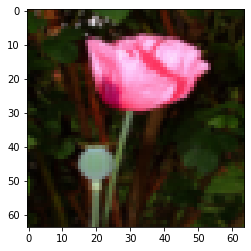

In [4]:
index = 30
plt.imshow(train_set_x_orig[index])
print("标签为"+str(train_set_y[:, index])+",这是一个"+classes[np.squeeze(train_set_y[:, index])].decode('utf-8')+'图片.')

In [5]:
# 维度检测：
def chack_and_tran():
    train_x_orig_shape = train_set_x_orig.shape # 将train_set_x_orig 的形状打印出来
    
    train_y_shape = train_set_y.shape
    
    test_x_orig_shape = train_set_x_orig.shape
    
    test_y_shape = test_set_y.shape
    
    train_x_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    # 将train_x维度进行扁平化
    test_x_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
    # 将test_x维度进行扁平化处理
    print(train_x_flat.shape)
    print(test_x_flat.shape)
    print('train_x_shape',train_x_orig_shape)
    print("train_y_shape",train_y_shape)
    print('test_x_shape',test_x_orig_shape)
    print("train_y_shape",test_y_shape)
    
    return train_x_flat, train_set_y, test_x_flat, test_set_y


In [6]:
def normaliztion_shape():
    train_x, train_y, test_x, test_y = chack_and_tran()
    
    train_x = train_x/225  # 进行简单的归一化
    test_x = test_x/225 
    
    
    return train_x, train_y, test_x, test_y

    
    

In [7]:
train_x, train_y, test_x, test_y = normaliztion_shape()


(12288, 209)
(12288, 50)
train_x_shape (209, 64, 64, 3)
train_y_shape (1, 209)
test_x_shape (209, 64, 64, 3)
train_y_shape (1, 50)


In [8]:
def init(dim):
    
    w = np.zeros((dim, 1))
    # 进行w的初始化 这个dim维度是输入层中输入的特征值这里是12288
    print('init_w_dim: (12288,1)',w.shape)
    
    b = 0 # 初始化b
    
    return w, b
    

In [9]:
def sigmoid(z):
    # sigmoid激活函数
    a = 1 / (1+np.exp(-z))
    
    return a

In [10]:
def propagate(w, b, x, y):
    
    m = x.shape[1]
#     print('propagete_m_dim == 12288', m)
#     print('propagate_x_shape == (12288, 209)', x.shape)
    z = np.dot(w.T, x)+b
#     print('progagete_z_shape == (1, 209)', z.shape)
    
    a = sigmoid(z)
#     print('progagete_a_dim == (1, 209)', a.shape)
    
#     print('cost_calcu_y_dim == (1, 209)', y.shape)
    
    
    cost = -np.sum(y*np.log(a) + (1-y)*np.log(1-a))/m
#     print(cost)

    # 反向传播 
    dz = a - y
#     print('dx_shape:(1, 129)',dz.shape)
#     print('x_shape:(12288, 209)',x.shape)
#     print('foward_dz_dim:(1, 209)',dz.shape)
    # dw = np.dot(dz, x.T) / 209 # shape(1, 12288)
    dw = np.dot(x, dz.T) / m # shape(12288, 1)
    # 
    db = np.sum(dz) / m
    grads = {'dw': dw, 'db':db}
    
    return cost, grads
    
    

In [11]:
def optimize(w, b, x, y, rate_num=0.01, iteration_num=1000):
    
    costs = []
    
    for i in range(iteration_num):
        
        cost, grads = propagate(w, b, x, y)
        
        # 从propagate函数中取出dw，db反向传播参数
        dw = grads['dw']
        db = grads['db']
        
        # 更新参数
        w = w - rate_num * dw
        # w(12288,1)
        # dw(12288,1)
        
        b = b - rate_num * db
#         print('optimize_b',b.shape)
        
        if i %100==0: 
            costs.append(cost)
            print('cost训练{}次后的损失函数是{}'.format(str(i),str(cost)))
           
            
    params = {
        "w":w,
        "b":b,
    }
    
    return params, costs
  

In [12]:
def predict(x, w, b):
    
    m = x.shape[1]
    Y_prediction = np.zeros((1,m))
    
    A = sigmoid(np.dot(w.T, x)+b)
#     w.T.shape(1, 12288)
#     x.shape(12288, 209)
    # output _shape(1, 209)

    for i in range(A.shape[1]):
        if A[0,i] >= 0.5:
            Y_prediction[0,i]=1
    return Y_prediction


In [13]:
def model(train_x, train_y, test_x, test_y, num_iterations = 2000, learning_rate = 0.5):
    dim = train_x.shape[0]
    
    w, b = init(dim)
                   
    params, costs = optimize(w, b, train_x, train_y , rate_num = learning_rate, iteration_num = num_iterations)
    
    w = params['w']
    b = params['b']
    
    y_predict_train = predict(train_x, w ,b)
    y_predict_test = predict(test_x, w, b)

    y_train_predict_num = 100 - np.mean(np.abs(y_predict_train - train_y)) * 100 
    
    y_test_predict_num = 100 - np.mean(np.abs(y_predict_test - test_y)) * 100
    
    print('训练集的准确率是{}'.format(y_train_predict_num))
    print("测试集的准确率是{}".format(y_test_predict_num))
    
    calculate_param = {
        "costs":costs,
        "w":w,
        "b":b,
        'y_train_predict':y_predict_train,
        'y_test_predict':y_predict_test,
        'learning_rate': learning_rate,
                      }
    return calculate_param

    
    
    
    

In [14]:
d = model(train_x, train_y, test_x, test_y, num_iterations = 2000, learning_rate = 0.005)




init_w_dim: (12288,1) (12288, 1)
cost训练0次后的损失函数是0.6931471805599453
cost训练100次后的损失函数是0.6666060975859165
cost训练200次后的损失函数是0.5615583969387856
cost训练300次后的损失函数是0.46266463118286616
cost训练400次后的损失函数是0.3697215338755504
cost训练500次后的损失函数是0.28703298392536947
cost训练600次后的损失函数是0.2381399865017567
cost训练700次后的损失函数是0.2196262517935603
cost训练800次后的损失函数是0.20423934868524005
cost训练900次后的损失函数是0.1908773282814838
cost训练1000次后的损失函数是0.1791284303638883
cost训练1100次后的损失函数是0.16870326984104778
cost训练1200次后的损失函数是0.1593846429074445
cost训练1300次后的损失函数是0.15100344749519248
cost训练1400次后的损失函数是0.14342484255036494
cost训练1500次后的损失函数是0.13653940417689656
cost训练1600次后的损失函数是0.13025710144273428
cost训练1700次后的损失函数是0.12450301588546238
cost训练1800次后的损失函数是0.11921420553516111
cost训练1900次后的损失函数是0.11433735218101772
训练集的准确率是99.52153110047847
测试集的准确率是68.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 50)
(1, 50)
这张图的标签是 1, 预测结果是 1


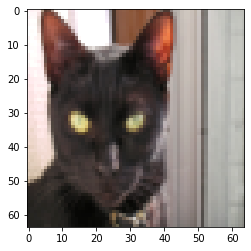

In [15]:
index = 9
plt.imshow(test_x[:, index].reshape((64,64,3)))
print(test_y.shape)
print(d["y_test_predict"].shape)
print ("这张图的标签是 " + str(test_y[0,index]) + ", 预测结果是 " + str(int(d["y_test_predict"][0,index])))

Text(0.5, 1.0, 'Learning rate=0.005')

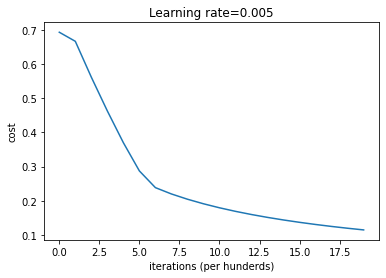

In [16]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hunderds)')
plt.title('Learning rate='+str(d['learning_rate']))


此图片中无猫


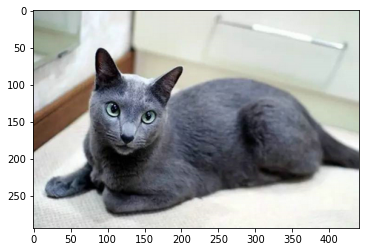

In [17]:
# 自己的图片输入到训练集好的参数中进行识别
image_path = '猫.jpg'
image = np.array(plt.imread(image_path))
my_image = tf.resize(image,(64, 64), mode = 'reflect').reshape(64*64*3, 1)
image_predict = predict(my_image, d['w'], d['b'])
if image_predict==1:
    print('此图片中有猫')
else:
    print('此图片中无猫')
plt.imshow(image)
